# Kaggle 필사 노트북
## Titanic - Machine Learning from Disaster

이 노트북은 Kaggle Titanic 대회의 필사 학습을 위해 작성되었습니다.  
Google Drive + Kaggle API + GitHub 연동 기반입니다.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Kaggle API 설정
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle_replica/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# titanic 데이터 다운로드

# !kaggle competitions download -c titanic
# !unzip titanic.zip

Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
# target_dir = "/content/drive/MyDrive/kaggle_replica/titanic"

# 파일 이동
# !mv train.csv {target_dir}/
# !mv test.csv {target_dir}/
# !mv gender_submission.csv {target_dir}/

In [7]:
import numpy as np
import pandas as pd
# 이 부분은 pd.Series(...)로 쓰는 것이 오히려 가독성 유지에 도움이 된다.
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('notebook', font_scale=1.2)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [8]:
# import pandas as pd

train_path = '/content/drive/MyDrive/kaggle_replica/titanic/train.csv'
test_path = '/content/drive/MyDrive/kaggle_replica/titanic/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# 1. Dataset 확인

In [9]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


해당 문제에서 feature는 Pclass, Age, SibSp, Parch, Fare 이며<br>
예측하려는 target label 은 Survived 이다.

## 🖇 describe() 함수

데이터프레임의 수치형(기본) 또는 전체 컬럼(옵션)을 요약 통계로 보여주는 함수

<br>

| 항목 | 의미 |
| --- | --- |
| `count` | 데이터 개수 (NaN은 제외) |
| `mean` | 평균 |
| `std` | 표준편차 (데이터의 흩어짐 정도) |
| `min` | 최소값 |
| `25%` | 1사분위수 (Q1) |
| `50%` | 중앙값 (Q2 / Median) |
| `75%` | 3사분위수 (Q3) |
| `max` | 최대값 |

<br>
Tip) 옵션 활용

```python
# 문자열(범주형) 컬럼도 포함하고 싶을 때
df.describe(include='all')
```
```python
# 특정 데이터 타입만 보고 싶을 때
df.describe(include=[object])     # 문자열(범주형)만
df.describe(include=[np.number])  # 수치형만 (기본값과 같음)
```

<br>

실제 분석에서 describe()로 알 수 있는 것

- 결측치 존재 여부 (`count` < 전체 row 수 → 결측 있음)
- 데이터의 분포가 왜곡되어 있는지 (`mean`, `std`, `min`, `max` 확인)
- 이상치(outlier)의 존재 가능성 (`max`나 `min`이 범위를 벗어날 때)
- 중앙값 vs 평균 비교로 분포 형태 파악
- 범주형 변수의 종류, 최빈값 확인 (`include='all'` 사용 시)


<br>


In [10]:
# describe(): 각 feature가 가진 통계치를 반환하는 pandas dataframe 함수
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
test_df.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


`PassengerId` 숫자와 다른 컬럼(feature), 즉 null data가 존재하는 feature가 있다는 것을 예상할 수 있다.

이를 보기 편하도록 시각화하여 살펴보자.

In [17]:
# train_df의 모든 컬럼에 대해 결측치 비율(%)을 계산하고 형식에 맞춰 출력한다.

# for col in train_df.columns:
#     msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(col, 100 * (train_df[col].isnull().sum() / train_df[col].shape[0]))
#     print(msg)

# My Code
for col in train_df.columns:
    # 1. isnull(): 결측치면 True, 아니면 False -> sum(): 결측치 개수
    # 2. shape[0]: 첫 번째 차원의 크기 -> 전체 행 개수
    # 3. 컬럼별 결측치 비율(%) 계산
    percent = 100 * (train_df[col].isnull().sum() / train_df[col].shape[0])
    # f-string으로 작성
    # col을 기준으로 문자열 오른쪽 정렬, 폭 11칸 확보
    msg = f'column: {col:>11}\t Percent of Nan value: {percent:.2f}%'
    print(msg)

column: PassengerId	 Percent of Nan value: 0.00%
column:    Survived	 Percent of Nan value: 0.00%
column:      Pclass	 Percent of Nan value: 0.00%
column:        Name	 Percent of Nan value: 0.00%
column:         Sex	 Percent of Nan value: 0.00%
column:         Age	 Percent of Nan value: 19.87%
column:       SibSp	 Percent of Nan value: 0.00%
column:       Parch	 Percent of Nan value: 0.00%
column:      Ticket	 Percent of Nan value: 0.00%
column:        Fare	 Percent of Nan value: 0.00%
column:       Cabin	 Percent of Nan value: 77.10%
column:    Embarked	 Percent of Nan value: 0.22%


# 1-1. Null data check

## 🖇 shape

DataFrame.shape 혹은 Series.shape는 **데이터의 크기(차원)**를 튜플로 보여준다.

```python
df.shape           # (891, 12)  → 891행 12열
df['Age'].shape    # (891,)     → 891행 (1차원 시리즈)
```
→ &nbsp;`shape[0]`은 "첫 번째 차원의 크기"
- `train_df[col]`은 `Series` (열 하나)
- `shape`는 (행 수,) 형태의 튜플
- `shape[0]`는 해당 열의 전체 행 개수

<br>

사실상 `len(train_df[col])`과 같다.

`shape[0]`은 넘파이/판다스 스타일로 좀 더 직관적이고 일관성 있게 사용된다.

<br>

In [18]:
for col in test_df.columns:
    percent = 100 * (test_df[col].isnull().sum() / test_df[col].shape[0])
    msg = f'column: {col:>11}\t Percent of Nan value: {percent:.2f}%'
    print(msg)

column: PassengerId	 Percent of Nan value: 0.00%
column:      Pclass	 Percent of Nan value: 0.00%
column:        Name	 Percent of Nan value: 0.00%
column:         Sex	 Percent of Nan value: 0.00%
column:         Age	 Percent of Nan value: 20.57%
column:       SibSp	 Percent of Nan value: 0.00%
column:       Parch	 Percent of Nan value: 0.00%
column:      Ticket	 Percent of Nan value: 0.00%
column:        Fare	 Percent of Nan value: 0.24%
column:       Cabin	 Percent of Nan value: 78.23%
column:    Embarked	 Percent of Nan value: 0.00%


Train, Test set에서 null data가 존재하는 것을 확인할 수 있다.

- Age: &nbsp;둘 다 약 20%
- Cabin: &nbsp;둘 다 약 80%
- Embarked: &nbsp;Train만 약 0.22%
- Fare: &nbsp;Test만 약 0.24%

<br>

## 🖇 missingno 라이브러리

pandas DataFrame의 결측치(NaN)를 시각적으로 파악할 수 있게 도와주는 라이브러리

- `msno.matrix(df)`: 결측치 분포를 세로선으로 시각화
- `msno.bar(df)`: 결측치 개수를 막대로 시각화
- `msno.heatmap(df)`: 결측치 상관관계 시각화

<br>



## 🖇 iloc

`iloc`은 pandas의 기본 기능으로, 숫자 인덱스로 행과 열을 선택할 때 사용하는 메서드

integer-location based indexing (숫자 기반 위치 인덱싱)

<br>

| index | Name | Age |
| --- | --- | --- |
| 0 | Alice | 25 |
| 1 | Bob | 30 |
| 2 | Charlie | 35 |


```python
df.iloc[0]      # 첫 번째 행 → Alice의 데이터
df.iloc[0, 1]   # 첫 번째 행의 두 번째 열 → 25
df.iloc[:, 0]   # 모든 행의 첫 번째 열 → Name 컬럼

```

<br>

`iloc` vs `loc`

| 구분 | 의미 | 예시 |
| --- | --- | --- |
| `iloc` | 숫자 기반 인덱싱 | `df.iloc[0, 1]` &nbsp;→ 25 |
| `loc` | 라벨(이름) 기반 인덱싱 | `df.loc[0, 'Age']` &nbsp;→ 25 |

<br>



<Axes: >

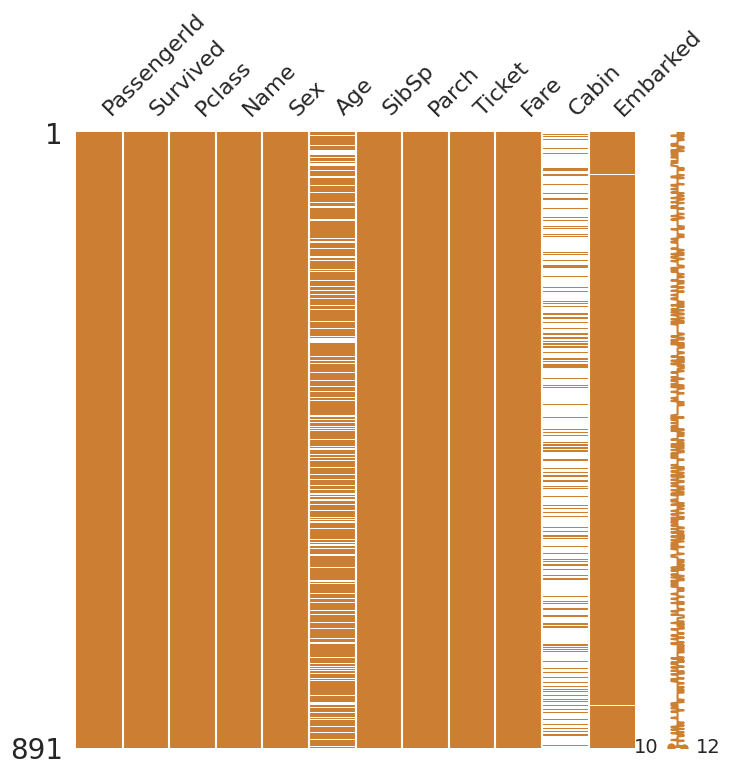

In [26]:
import missingno as msno

# msno.matrix(df=시각화할 DataFrame, figsize=그래프 크기, color=채워진 값 색상)

# 1. iloc: 행, 열 숫자를 인덱스로 선택 (-> 전체 행, 전체 열 선택)
#    = msno.matrix(train_df)
# 2. figsize = (가로, 세로): 단위는 inch. matplotlib의 기본 설정과 같음
# 3. color = (R, G, B): 채워진 부분 색상. 결측치는 기본적으로 흰색으로 표시됨
msno.matrix(df=train_df.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

Q. &nbsp;`figsize=(8, 8)`로, 시각적으로 '가로 = 세로' 로 지정했는데 왜 세로로 더 긴 비율로 출력되는 걸까?

<br>

이유 1. 행(row)의 수가 열(col)보다 훨씬 많기 때문

&nbsp;→ &nbsp;내용이 꽉 차면 비율보다 내용 우선으로 확대된다.

이유 2. matplotlib이 기본적으로 화면 DPI나 컨텐츠 크기에 따라 figure 크기를 자동 조절하기 때문

&nbsp;→ &nbsp;figsize는 "기본 캔버스의 크기"일 뿐,

&nbsp;→ &nbsp;`missingno.matrix()` 내부에서 `sns.heatmap`처럼 layout을 자동으로 바꿔 출력


💡 &nbsp;즉, 행 개수가 많아서 missingno가 자동으로 세로 길이를 늘린 것이다.

<br>
Tip) 아래처럼 하면 가로는 여유롭고, 세로는 압축되어 비율이 맞아 보일 수 있다.

```python
# 가로로 더 넓게
msno.matrix(train_df, figsize=(12, 4))
```



<Axes: >

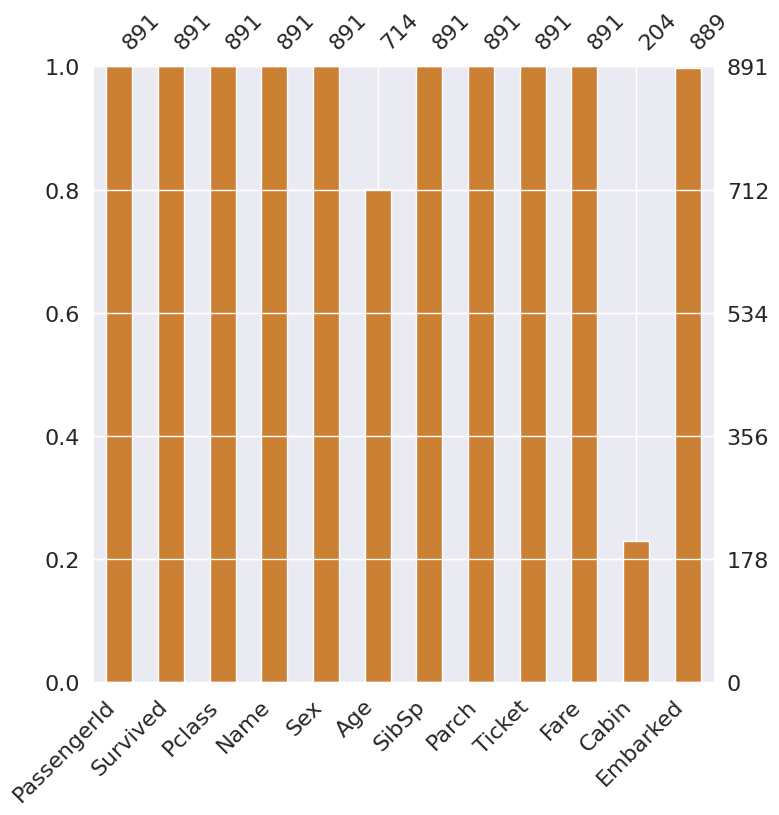

In [29]:
msno.bar(df=train_df.iloc[:, :], figsize =(8, 8), color=(0.8, 0.5, 0.2))

<Axes: >

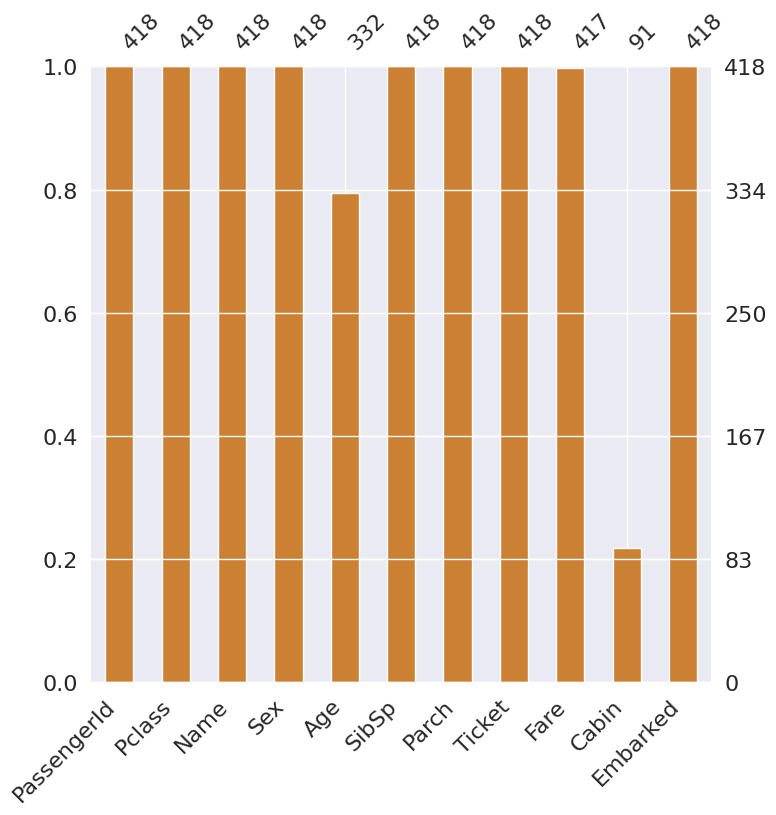

In [30]:
msno.bar(df=test_df.iloc[:, :], figsize=(8, 8), color=(0.8, 0.5, 0.2))

# 1-2. Target label 확인

target label(Survived)이 어떤 distribution을 가지고 있는지 확인해야 한다.

지금 같은 binary classification 문제의 경우, 1과 0의 분포가 어떠냐에 따라 모델의 평가 방법이 달라질 수 있다.

## 🖇 plt.subplots()

여러 개의 그래프(서브 플롯)를 한 번에 배치하는 matplotlib.pyplot 라이브러리 함수

`f, ax = plt.subplots(nrows=1, ncols=2, figsize=(가로, 세로))`

→ &nbsp;`f`는 전체 그래프 (figure), `ax`는 각각의 작은 그래프 영역 (Axes)

```python
# ax는 리스트처럼 사용 가능
ax[0]  # 왼쪽 그래프
ax[1]  # 오른쪽 그래프
```

<br>

## 🖇 value_counts()

범주형 값을 세는 데 유용한 pandas 라이브러리 함수

`value_counts(normalize=True)` 옵션으로 비율(%)로도 확인 가능

<br>

## 🖇 plot.pie()

숫자를 원형 차트로 그리는 pandas 라이브러리 함수

| 인자 | 뜻 |
| --- | --- |
| `explode=[0, 0.1]` | 두 번째 조각(생존자)을 약간 분리 |
| `autopct='%1.1f%%'` | 각 조각 위에 비율을 1자리 소수로 표시 |
| `ax=ax[0]` | 첫 번째 그래프 영역(왼쪽)에 그려라 |
| `shadow=True` | 파이차트에 그림자 추가해서 입체감 줌 |
| `labels`| 범주 이름 직접 지정 |

<br>

## 🖇 sns.countplot()

범주형(카테고리형) 데이터의 빈도(횟수)를 세서 막대그래프로 시각화하는 seaborn 라이브러리 함수

| 파라미터 | 설명 |
| --- | --- |
| `x`, `y` | 기준 컬럼 (`x='Survived'` or `y='Survived'`) |
| `data` | 사용할 DataFrame |
| `hue` | 서브그룹 분리 (예: 성별에 따라 생존 여부 나누기) |
| `ax` | 특정 matplotlib subplot에 그릴 때 |
| `palette` | 색상 설정 |
| `order` | 카테고리 순서 지정 |

```python
# 예시) 성별에 따른 생존자 수
sns.countplot(x='Sex', hue='Survived', data=train_df)
```

사용 1. 범주형 데이터의 분포 파악

사용 2. EDA에서 클래스 불균형 확인

머신러닝에서는 클래스 간 데이터 분포가 중요하다. 예를 들어 Survived = 0이 3배 더 많다면, 모델 성능이 왜곡될 수 있다.

→ &nbsp;시각화로 확인하고, 언더샘플링/오버샘플링 같은 대응이 가능함


Tip) &nbsp;`countplot()` &nbsp;vs &nbsp;`barplot()`

| 항목 | countplot() | barplot() |
|------|-------------|-----------|
| 목적 | 범주별 개수 시각화 | 범주별 수치(평균 등) 시각화 |
| y축 | 자동으로 빈도(count) | 수치(평균, 합계 등) |
| 사용 예 | 성별별 생존자 수 | 성별별 나이 평균 비교 |

<br>


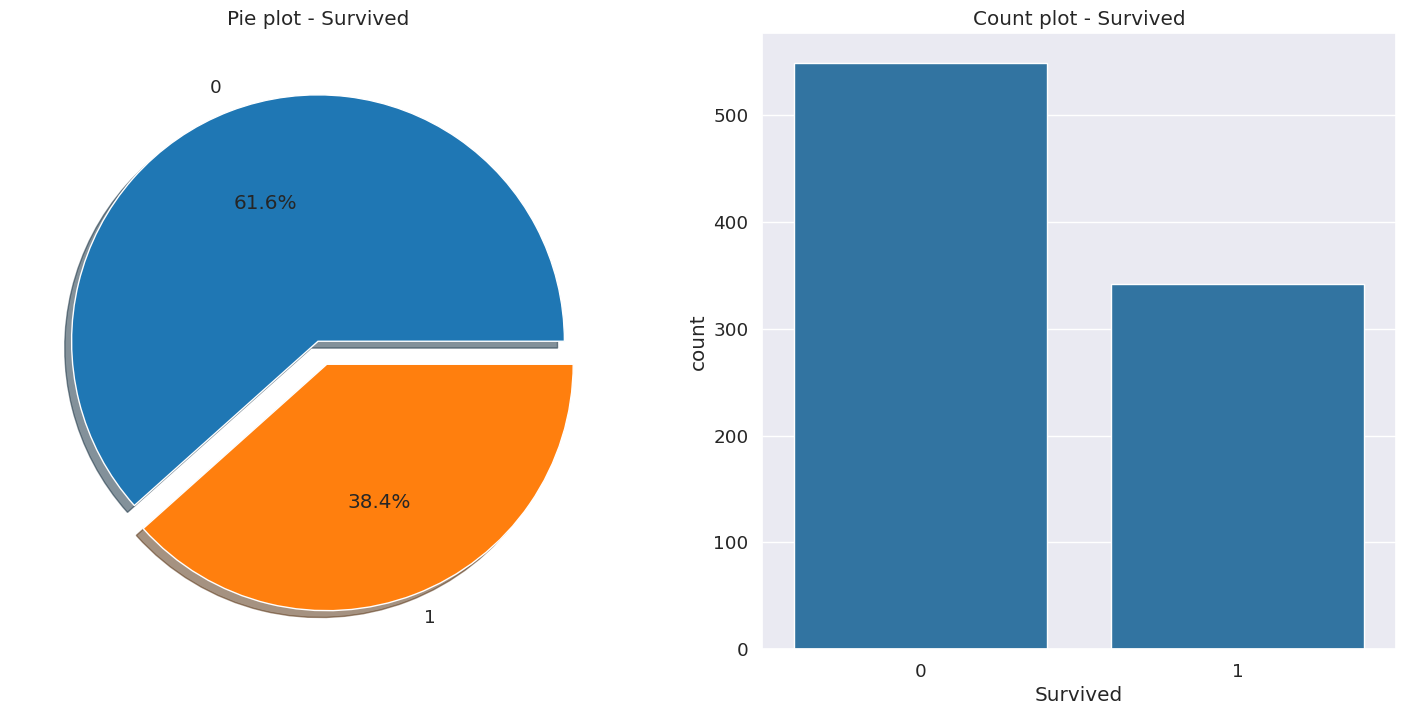

In [34]:
# matplotlib + seaborn 으로
# 타이타닉 데이터의 생존 여부(Survived)를 원형 차트(Pie chart)와 막대그래프(Count plot)로 시각화한다.

# f는 전체 그래프 (figure), ax는 각각의 작은 그래프 영역 (Axes)
# (1, 2): 1행 2열 → 옆으로 2개의 그래프
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# 원형 차트 그리기 (비율 확인)
train_df['Survived'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')  # y축 라벨 제거 (원형 그래프는 세로축이 중요하지 않으므로 깔끔하게 정리)

# 막대 차트 그리기 (개수 확인)
# x='Survived'로 명시적으로 지정하지 않으면
# countplot()은 내부적으로 'Survived가 x=... 인지, data=... 인지 판단을 못함
# -> TypeError: got multiple values for argument 'data'
sns.countplot(x='Survived', data=train_df, ax=ax[1])
ax[1].set_title('Count plot - Survived')

# 그래프 전체 출력 - matplotlib에서 시각화를 마무리해야 출력됨
plt.show()